In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
# from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tools.eval_measures import rmse  # not used
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from patsy import dmatrices
from math import sqrt
# from statsmodels.formula.api import ols
# %matplotlib inline

# 3.6.2 - simple linear regression
Export data from R:
```
library(ISLR2)
write.csv(Boston, "boston.csv", row.names=F)
```

In [2]:
boston = pd.read_csv('../data/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


R - fit a linear regression: 
```
attach(Boston)
lm.fit = lm(medv ~ lstat)
```

In [3]:
y = boston['medv'].to_numpy().reshape(-1, 1)
X = boston['lstat'].to_numpy().reshape(-1, 1)
sklearn_model = LinearRegression()
sklearn_model.fit(X, y)

LinearRegression()

R - showing intercept and coefficient: `lm.fit` or `coef(lm.fit)`

In [4]:
print(f'Intercept: {sklearn_model.intercept_}, Coefficeint (lstat): {sklearn_model.coef_}')

Intercept: [34.55384088], Coefficeint (lstat): [[-0.95004935]]


To get a more equivilent report to R's `summary(lm.fit)`, use `statsmodels`.
There exists no R type regression summary report in sklearn. The main reason is 
that sklearn is used for predictive modelling / machine learning and the evaluation 
criteria are based on performance on previously unseen data (such as predictive r^2 
for regression).

More info: https://datatofish.com/statsmodels-linear-regression/

In [5]:
sm_X = sm.add_constant(X)
sm_model = sm.OLS(y, sm_X).fit()
predictions = sm_model.predict(sm_X) 
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 27 Mar 2022   Prob (F-statistic):           5.08e-88
Time:                        10:14:00   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.000      33.448      35.659
x1            -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# R summary comparison
Data in both summaries:
- Coefficients match Python
- Multiple R-squared is R-squared in Python
- Adjusted R-squard is Adj. R-squared in Python
- F-statistic is F-statistic in Python
    - the "1 and 504 DF" can be found in DF Model and DF Residuals in Python
- p-value is likely under the P>|t| section, but so small it's showing 0 instead of 2.2e-16 in Python

Data missing from Python:
- Residuals (Min, 1Q, Median, 3Q, Max)
- Residual standard error (504 is listed, but not 6.216)
- Signif. codes

```
Residuals:
    Min      1Q  Median      3Q     Max 
-15.168  -3.990  -1.318   2.034  24.500 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 34.55384    0.56263   61.41   <2e-16 ***
lstat       -0.95005    0.03873  -24.53   <2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.216 on 504 degrees of freedom
Multiple R-squared:  0.5441,	Adjusted R-squared:  0.5432 
F-statistic: 601.6 on 1 and 504 DF,  p-value: < 2.2e-16
```

R - obtain a confidence interval for the coefficient estimates: 
```
> confint(lm.fit)
                2.5 %     97.5 %
(Intercept) 33.448457 35.6592247
lstat       -1.026148 -0.8739505
```

In [6]:
# The default alpha = .05 returns a 95% confidence interval.
sm_model.conf_int(alpha=0.05, cols=None)

array([[33.44845704, 35.65922472],
       [-1.0261482 , -0.87395051]])

Producing confidence intervals for medv for a given value of lstat
```
> predict(lm.fit, data.frame(lstat=(c(5, 10, 15))), interval="confidence")
       fit      lwr      upr
1 29.80359 29.00741 30.59978
2 25.05335 24.47413 25.63256
3 20.30310 19.73159 20.87461
```

In [7]:
sm_model.get_prediction(sm.add_constant([5, 10, 15])).summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']]

,mean,mean_ci_lower,mean_ci_upper
0,29.803594,29.007412,30.599776
1,25.053347,24.474132,25.632563
2,20.303101,19.731588,20.874613


Producing prediction intervals for medv for a given value of lstat
```
> predict(lm.fit, data.frame(lstat=(c(5, 10, 15))), interval="prediction")
       fit       lwr      upr
1 29.80359 17.565675 42.04151
2 25.05335 12.827626 37.27907
3 20.30310  8.077742 32.52846
```

In [8]:
sm_model.get_prediction(sm.add_constant([5, 10, 15])).summary_frame()[['mean', 'obs_ci_lower', 'obs_ci_upper']]

,mean,obs_ci_lower,obs_ci_upper
0,29.803594,17.565675,42.041513
1,25.053347,12.827626,37.279068
2,20.303101,8.077742,32.528459


Plot along with least squares regression
```
plot(lstat, medv)
abline(lm.fit)
```
![regression](images/least_square_regression.png)

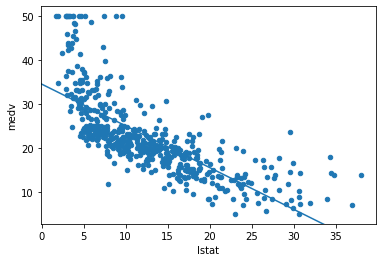

In [9]:
ax = boston.plot.scatter(x='lstat', y='medv')
abline_plot(model_results=sm_model, ax=ax)
plt.show()

Split screen into separate panels
```
par(mfrow=c(2, 2))
plot(lm.fit)
```
![grid plot](images/2_2_grid_plot.png)

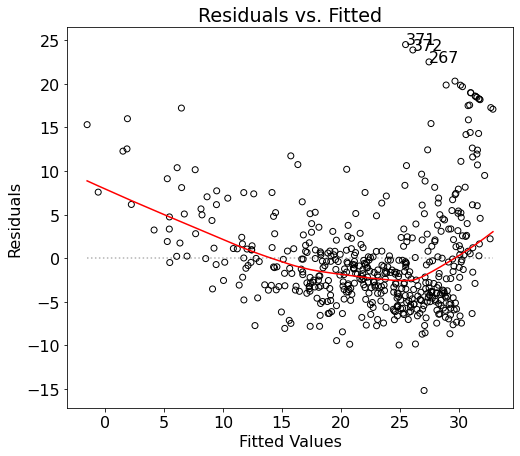

In [10]:
# https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a
# note the R notation in formula.api.ols
def residuals_vs_fitted(results, smoothing=True):
    residuals = results.resid
    fitted = results.fittedvalues
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 16})
    plt.rcParams["figure.figsize"] = (8,7)
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    if smoothing == True:
        smoothed = lowess(residuals, fitted)
        ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

    plt.show()

results = smf.ols("medv ~ lstat", data=boston).fit()
residuals_vs_fitted(results)

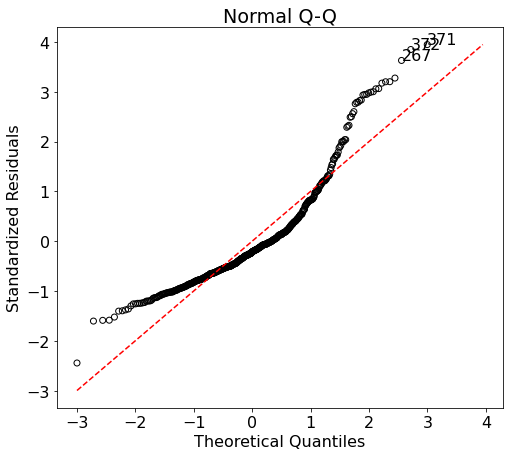

In [11]:
def normal_q_q(results):
    sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = results.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    plt.show()

normal_q_q(results)

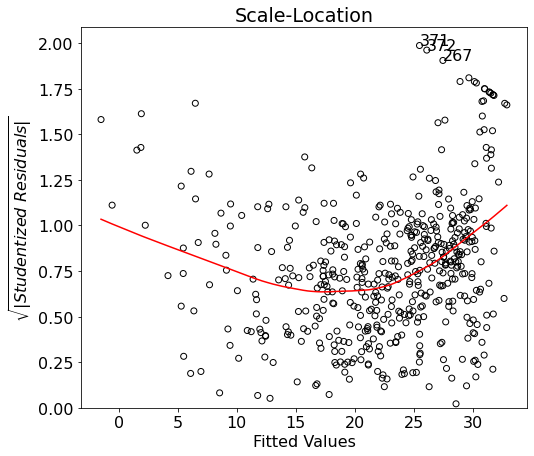

In [12]:
def scale_location(results, fitted, smoothing=True):
    student_residuals = results.get_influence().resid_studentized_internal
    
    fig, ax = plt.subplots()
    
    if smoothing == True:
        sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
        sqrt_student_residuals.index = results.resid.index
        smoothed = lowess(sqrt_student_residuals,fitted)
        top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]
        ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
        ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
        ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
        ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
        for i in top3.index:
            ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
    else:
        ax.scatter(fitted, student_residuals, edgecolors = 'k', facecolors = 'none')
        ax.set_ylabel('Studentized Residuals')
        ax.set_ylim(min(student_residuals)-0.1,max(student_residuals)+0.1)
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')
    
    
    plt.show()

fitted = results.fittedvalues
scale_location(results, fitted)

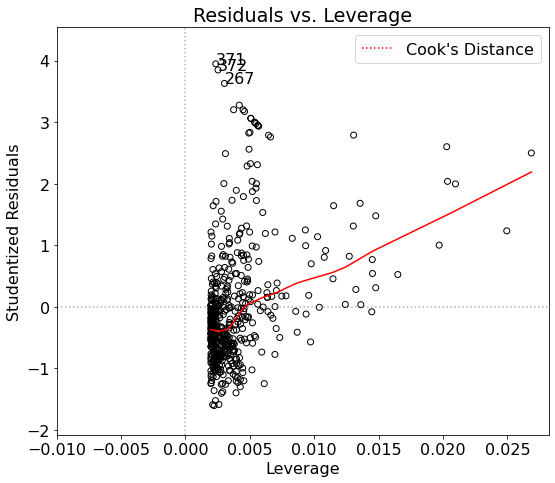

In [13]:
def residuals_vs_leverage(results):
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    fig, ax = plt.subplots()
    x = df['leverage']
    y = df['student_residuals']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top3.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(results.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    plt.show()

residuals_vs_leverage(results)

In [14]:
# TODO: combine functions above into a single function, save as python module to import for future use

Plot residuals: `plot(predict(lm.fit), residuals(lm.fit))`

![predict_residuals](images/predict_residuals.png)

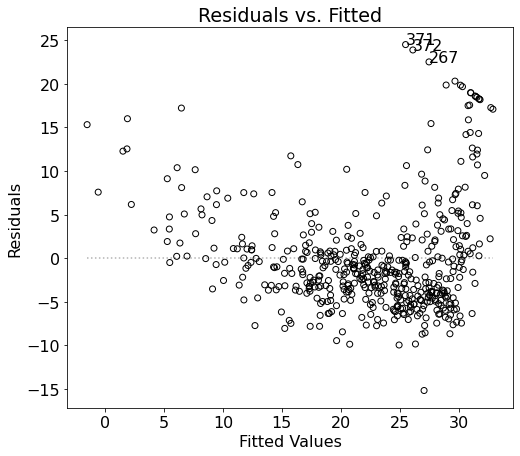

In [15]:
# looks like residuals_vs_fitted() minus smoothed red line
residuals_vs_fitted(results, smoothing=False)

Plot residuals: `plot(predict(lm.fit), rstudent(lm.fit))`

![predict_rstudent](images/predict_rstudent.png)

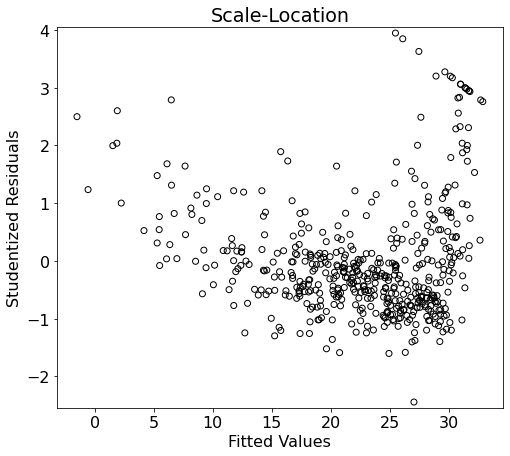

In [16]:
# looks like scale_location() minus smoothed red line, no square root on y
scale_location(results, fitted, smoothing=False)

Plot leverage stats: `plot(hatvalues(lm.fit))`

![leverage](images/leverage.png)

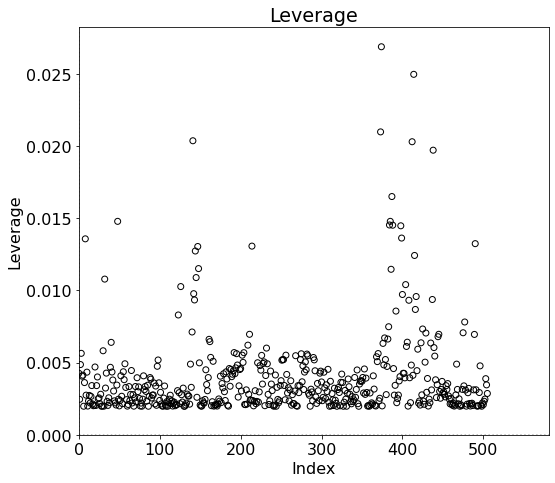

In [17]:
# may be like residuals vs leverage, with axis flipped, different scale for index
def plot_hatvalues(results):
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    fig, ax = plt.subplots()
    y = df['leverage']
    x = df.index
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
    ax.set_xlabel('Index')
    ax.set_ylabel('Leverage')
    ax.set_title('Leverage')
    ax.set_xlim(min(x)-min(x)*0.15,max(x)+max(x)*0.15)
    ax.set_ylim(0,max(y)+max(y)*0.05)
    plt.tight_layout()

    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    
    plt.show()

plot_hatvalues(results)

# 3.6.3 - multiple linear regression
R syntax: `lm(y ∼ x1 + x2 + x3)` is used to fit a model with three predictors, x1, x2, and x3
```
lm.fit = lm(medv ~ lstat + age, data=Boston)
```

> For more on using R-style formulas in statsmodels: https://www.statsmodels.org/dev/example_formulas.html

In [18]:
mlr_results = smf.ols("medv ~ lstat + age", data=boston).fit()

```
> summary(lm.fit)

Call:
lm(formula = medv ~ lstat + age, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.981  -3.978  -1.283   1.968  23.158 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 33.22276    0.73085  45.458  < 2e-16 ***
lstat       -1.03207    0.04819 -21.416  < 2e-16 ***
age          0.03454    0.01223   2.826  0.00491 ** 
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.173 on 503 degrees of freedom
Multiple R-squared:  0.5513,	Adjusted R-squared:  0.5495 
F-statistic:   309 on 2 and 503 DF,  p-value: < 2.2e-16
```

In [19]:
mlr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Sun, 27 Mar 2022   Prob (F-statistic):           2.98e-88
Time:                        10:14:00   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.000      31.787      34.659
lstat         -1.0321      0.048    -21.416      0.000      -1.127      -0.937
age            0.0345      0.012      2.826      0.005       0.011       0.059
==============================================================================
Omnibus:                      124.288   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.026
Skew:                           1.362   Prob(JB):                     1.02e-53
Kurtosis:                       5.038   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Multiple linear regression using all predictors
```
> lm.fit = lm(medv ~ ., data=Boston)
> summary(lm.fit)

Call:
lm(formula = medv ~ ., data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.595  -2.730  -0.518   1.777  26.199 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.646e+01  5.103e+00   7.144 3.28e-12 ***
crim        -1.080e-01  3.286e-02  -3.287 0.001087 ** 
zn           4.642e-02  1.373e-02   3.382 0.000778 ***
indus        2.056e-02  6.150e-02   0.334 0.738288    
chas         2.687e+00  8.616e-01   3.118 0.001925 ** 
nox         -1.777e+01  3.820e+00  -4.651 4.25e-06 ***
rm           3.810e+00  4.179e-01   9.116  < 2e-16 ***
age          6.922e-04  1.321e-02   0.052 0.958229    
dis         -1.476e+00  1.995e-01  -7.398 6.01e-13 ***
rad          3.060e-01  6.635e-02   4.613 5.07e-06 ***
tax         -1.233e-02  3.760e-03  -3.280 0.001112 ** 
ptratio     -9.527e-01  1.308e-01  -7.283 1.31e-12 ***
black        9.312e-03  2.686e-03   3.467 0.000573 ***
lstat       -5.248e-01  5.072e-02 -10.347  < 2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.745 on 492 degrees of freedom
Multiple R-squared:  0.7406,	Adjusted R-squared:  0.7338 
F-statistic: 108.1 on 13 and 492 DF,  p-value: < 2.2e-16
```

In [20]:
# no support for . operator, so we'll make a list of everything but y and concatenate with +
all_columns_list = boston.columns.to_list()
all_columns_list.remove('medv')
all_columns = "+".join(all_columns_list)
mlr_results = smf.ols(f"medv ~ {all_columns}", data=boston).fit()
mlr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          2.23e-133
Time:                        10:14:00   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.6173      4.936      8.431      0.000      31.919      51.316
crim          -0.1214      0.033     -3.678      0.000      -0.186      -0.057
zn             0.0470      0.014      3.384      0.001       0.020       0.074
indus          0.0135      0.062      0.217      0.829      -0.109       0.136
chas           2.8400      0.870      3.264      0.001       1.131       4.549
nox          -18.7580      3.851     -4.870      0.000     -26.325     -11.191
rm             3.6581      0.420      8.705      0.000       2.832       4.484
age            0.0036      0.013      0.271      0.787      -0.023       0.030
dis           -1.4908      0.202     -7.394      0.000      -1.887      -1.095
rad            0.2894      0.067      4.325      0.000       0.158       0.421
tax           -0.0127      0.004     -3.337      0.001      -0.020      -0.005
ptratio       -0.9375      0.132     -7.091      0.000      -1.197      -0.678
lstat         -0.5520      0.051    -10.897      0.000      -0.652      -0.452
==============================================================================
Omnibus:                      171.096   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.937
Skew:                           1.477   Prob(JB):                    6.90e-155
Kurtosis:                       7.995   Cond. No.                     1.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Get r squared.  
```
> summary(lm.fit)$r.sq
[1] 0.7406427
```
> Note: after a boston data update removing black column, seeing 0.734307 in R

In [21]:
mlr_results.rsquared

0.7343070437613076

Get RSE
```
> summary(lm.fit)$sigma
[1] 4.745298
```
> Note: after a boston data update removing black column, seeing 4.798034 in R

In [22]:
sqrt(mlr_results.mse_resid)

4.798034335596367

Calculate variance inflation factors
```
> vif(lm.fit)
    crim       zn    indus     chas      nox       rm 
1.767486 2.298459 3.987181 1.071168 4.369093 1.912532 
     age      dis      rad      tax  ptratio    lstat 
3.088232 3.954037 7.445301 9.002158 1.797060 2.870777 
```

In [23]:
# get y and X dataframes based on this regression
y_df, X_df = dmatrices('medv ~' + all_columns, boston, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif["features"] = X_df.columns
vif

,VIF Factor,features
0,535.526619,Intercept
1,1.767486,crim
2,2.298459,zn
3,3.987181,indus
4,1.071168,chas
5,4.369093,nox
6,1.912532,rm
7,3.088232,age
8,3.954037,dis
9,7.445301,rad


Run a regression excluding age since it has a high p-vaulue
```
> lm.fit1 = lm(medv ~ . - age, data=Boston)
> summary(lm.fit1)

Call:
lm(formula = medv ~ . - age, data = Boston)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.1851  -2.7330  -0.6116   1.8555  26.3838 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  41.525128   4.919684   8.441 3.52e-16 ***
crim         -0.121426   0.032969  -3.683 0.000256 ***
zn            0.046512   0.013766   3.379 0.000785 ***
indus         0.013451   0.062086   0.217 0.828577    
chas          2.852773   0.867912   3.287 0.001085 ** 
nox         -18.485070   3.713714  -4.978 8.91e-07 ***
rm            3.681070   0.411230   8.951  < 2e-16 ***
dis          -1.506777   0.192570  -7.825 3.12e-14 ***
rad           0.287940   0.066627   4.322 1.87e-05 ***
tax          -0.012653   0.003796  -3.333 0.000923 ***
ptratio      -0.934649   0.131653  -7.099 4.39e-12 ***
lstat        -0.547409   0.047669 -11.483  < 2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.794 on 494 degrees of freedom
Multiple R-squared:  0.7343,	Adjusted R-squared:  0.7284 
F-statistic: 124.1 on 11 and 494 DF,  p-value: < 2.2e-16

> # can also modify a model using update
> lm.fit1 = update(lm.fit, ~ . - age)
> summary(lm.fit1)
```

In [24]:
# no support for . operator
columns_no_age_list = all_columns_list.copy()
columns_no_age_list.remove('age')
all_columns_no_age = "+".join(columns_no_age_list)
mlr_results_no_age = smf.ols(f"medv ~ {all_columns_no_age}", data=boston).fit()
mlr_results_no_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     124.1
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          2.03e-134
Time:                        10:14:00   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3034.
Df Residuals:                     494   BIC:                             3085.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5251      4.920      8.441      0.000      31.859      51.191
crim          -0.1214      0.033     -3.683      0.000      -0.186      -0.057
zn             0.0465      0.014      3.379      0.001       0.019       0.074
indus          0.0135      0.062      0.217      0.829      -0.109       0.135
chas           2.8528      0.868      3.287      0.001       1.148       4.558
nox          -18.4851      3.714     -4.978      0.000     -25.782     -11.188
rm             3.6811      0.411      8.951      0.000       2.873       4.489
dis           -1.5068      0.193     -7.825      0.000      -1.885      -1.128
rad            0.2879      0.067      4.322      0.000       0.157       0.419
tax           -0.0127      0.004     -3.333      0.001      -0.020      -0.005
ptratio       -0.9346      0.132     -7.099      0.000      -1.193      -0.676
lstat         -0.5474      0.048    -11.483      0.000      -0.641      -0.454
==============================================================================
Omnibus:                      172.506   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              724.941
Skew:                           1.485   Prob(JB):                    3.81e-158
Kurtosis:                       8.056   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3.6.4 - Interaction Terms
The syntax lstat * age simultaneously includes lstat, age, and the interaction term lstat×age as predictors; it is a short- hand for lstat + age + lstat:age.
```
> summary(lm(medv ~ lstat * age, data=Boston))

Call:
lm(formula = medv ~ lstat * age, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.806  -4.045  -1.333   2.085  27.552 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 36.0885359  1.4698355  24.553  < 2e-16 ***
lstat       -1.3921168  0.1674555  -8.313 8.78e-16 ***
age         -0.0007209  0.0198792  -0.036   0.9711    
lstat:age    0.0041560  0.0018518   2.244   0.0252 *  
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.149 on 502 degrees of freedom
Multiple R-squared:  0.5557,	Adjusted R-squared:  0.5531 
F-statistic: 209.3 on 3 and 502 DF,  p-value: < 2.2e-16
```

In [25]:
mlr_results_interaction = smf.ols(f"medv ~ lstat * age", data=boston).fit()
mlr_results_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Sun, 27 Mar 2022   Prob (F-statistic):           4.86e-88
Time:                        10:14:00   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.000      33.201      38.976
lstat         -1.3921      0.167     -8.313      0.000      -1.721      -1.063
age           -0.0007      0.020     -0.036      0.971      -0.040       0.038
lstat:age      0.0042      0.002      2.244      0.025       0.001       0.008
==============================================================================
Omnibus:                      135.601   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.955
Skew:                           1.417   Prob(JB):                     3.29e-65
Kurtosis:                       5.461   Cond. No.                     6.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3.6.5 - Non-linear Transformations of the Predictors
To perform a regression of medv onto lstat and lstat2:
```
> lm.fit2 = lm(medv ~ lstat + I(lstat^2))
> summary(lm.fit2)

Call:
lm(formula = medv ~ lstat + I(lstat^2))

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2834  -3.8313  -0.5295   2.3095  25.4148 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 42.862007   0.872084   49.15   <2e-16 ***
lstat       -2.332821   0.123803  -18.84   <2e-16 ***
I(lstat^2)   0.043547   0.003745   11.63   <2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.524 on 503 degrees of freedom
Multiple R-squared:  0.6407,	Adjusted R-squared:  0.6393 
F-statistic: 448.5 on 2 and 503 DF,  p-value: < 2.2e-16
```

In [28]:
mlr_results_non_linear = smf.ols(f"medv ~ lstat + I(lstat**2)", data=boston).fit()
mlr_results_non_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          1.56e-112
Time:                        10:14:49   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149      0.000      41.149      44.575
lstat            -2.3328      0.124    -18.843      0.000      -2.576      -2.090
I(lstat ** 2)     0.0435      0.004     11.628      0.000       0.036       0.051
==============================================================================
Omnibus:                      107.006   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.388
Skew:                           1.128   Prob(JB):                     2.55e-50
Kurtosis:                       5.397   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Use anova to quantify that quadratic is superior
```
> anova(lm.fit, lm.fit2)
Analysis of Variance Table

Model 1: medv ~ lstat
Model 2: medv ~ lstat + I(lstat^2)
  Res.Df   RSS Df Sum of Sq     F    Pr(>F)    
1    504 19472                                 
2    503 15347  1    4125.1 135.2 < 2.2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

In [29]:
table = sm.stats.anova_lm(mlr_results_non_linear, typ=2)
table

,sum_sq,df,F,PR(>F)
lstat,10833.300262,1.0,355.057255,2.548861e-60
I(lstat ** 2),4125.138260,1.0,135.199822,7.630116e-28
Residual,15347.243158,503.0,NaN,NaN


This illustrates that with lstat^2 included there is little discernable pattern in residuals
```
> par(mfrow = c(2, 2))
> plot(lm.fit2)
```
![lstat2_residuals](images/lstat2_residuals.png)


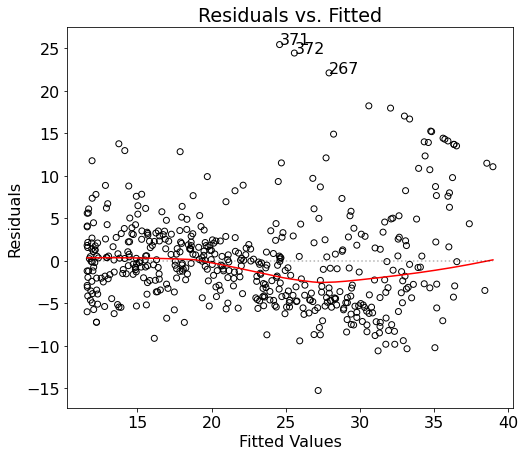

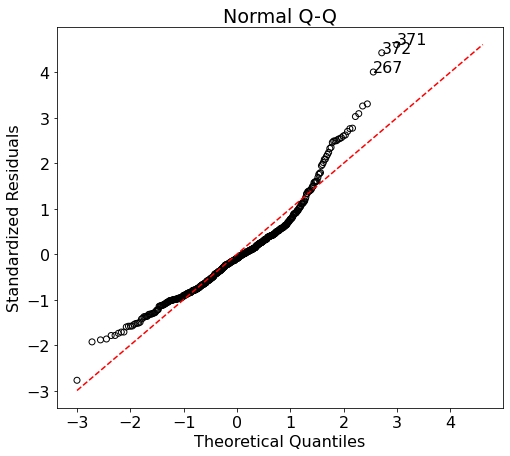

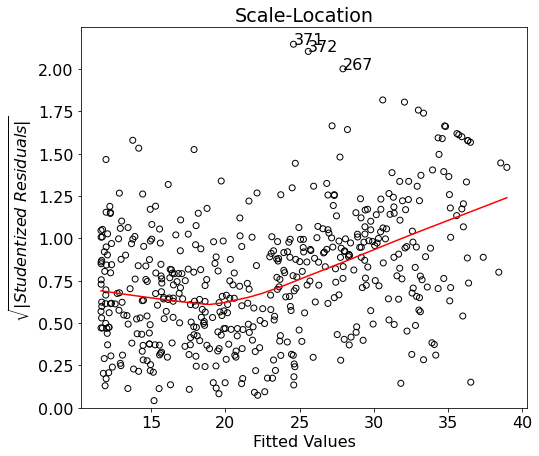

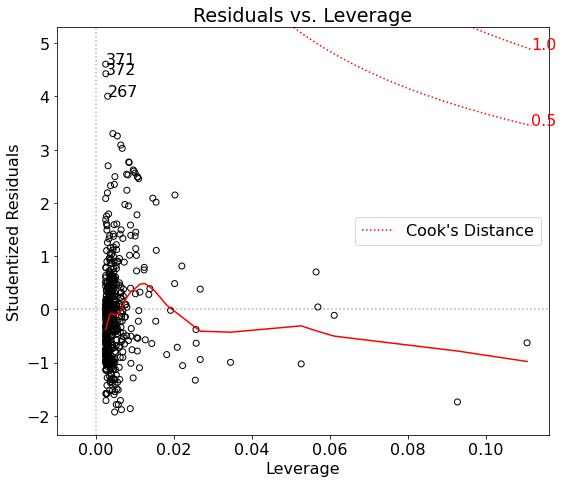

In [30]:
def r_plot(results, fitted):
    residuals_vs_fitted(results)
    # residuals_vs_fitted(results, smoothing=False)  # results
    normal_q_q(results)
    scale_location(results, fitted)
    residuals_vs_leverage(results)
non_linear_fitted = mlr_results_non_linear.fittedvalues
r_plot(mlr_results_non_linear, non_linear_fitted)

Create a fifth-order polynomial fit
```
> lm.fit5 = lm(medv ~ poly(lstat, 5))
> summary(lm.fit5)

Call:
lm(formula = medv ~ poly(lstat, 5))

Residuals:
     Min       1Q   Median       3Q      Max 
-13.5433  -3.1039  -0.7052   2.0844  27.1153 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)       22.5328     0.2318  97.197  < 2e-16
poly(lstat, 5)1 -152.4595     5.2148 -29.236  < 2e-16
poly(lstat, 5)2   64.2272     5.2148  12.316  < 2e-16
poly(lstat, 5)3  -27.0511     5.2148  -5.187 3.10e-07
poly(lstat, 5)4   25.4517     5.2148   4.881 1.42e-06
poly(lstat, 5)5  -19.2524     5.2148  -3.692 0.000247
                   
(Intercept)     ***
poly(lstat, 5)1 ***
poly(lstat, 5)2 ***
poly(lstat, 5)3 ***
poly(lstat, 5)4 ***
poly(lstat, 5)5 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.215 on 500 degrees of freedom
Multiple R-squared:  0.6817,	Adjusted R-squared:  0.6785 
F-statistic: 214.2 on 5 and 500 DF,  p-value: < 2.2e-16
```

Although the statsmodels formula API (in fact Patsy library) doesn't support poly(variable, degree) function as in R, NumPy's vander(variable, degree+1) can do the job.  https://stackoverflow.com/questions/61899474/polynomial-regression-using-statsmodels-formula-api

In [45]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(X)
xp.shape
poly_model = sm.OLS(y, xp).fit()
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          8.73e-122
Time:                        10:22:12   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.6997      3.604     18.783      0.000      60.618      74.781
x1           -11.9911      1.526     -7.859      0.000     -14.989      -8.994
x2             1.2728      0.223      5.703      0.000       0.834       1.711
x3            -0.0683      0.014     -4.747      0.000      -0.097      -0.040
x4             0.0017      0.000      4.143      0.000       0.001       0.003
x5         -1.632e-05   4.42e-06     -3.692      0.000    -2.5e-05   -7.63e-06
==============================================================================
Omnibus:                      144.085   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.545
Skew:                           1.292   Prob(JB):                    4.08e-108
Kurtosis:                       7.096   Cond. No.                     1.37e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
poly_mlr_results = smf.ols(formula='medv ~ np.vander(lstat, 5, increasing=True) - 1', data=boston).fit()
poly_mlr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     257.8
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          4.16e-120
Time:                        10:14:50   Log-Likelihood:                -1557.4
No. Observations:                 506   AIC:                             3125.
Df Residuals:                     501   BIC:                             3146.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
np.vander(lstat, 5, increasing=True)[0]    57.3100      2.280     25.134      0.000      52.830      61.790
np.vander(lstat, 5, increasing=True)[1]    -7.0285      0.731     -9.618      0.000      -8.464      -5.593
np.vander(lstat, 5, increasing=True)[2]     0.4955      0.075      6.616      0.000       0.348       0.643
np.vander(lstat, 5, increasing=True)[3]    -0.0163      0.003     -5.448      0.000      -0.022      -0.010
np.vander(lstat, 5, increasing=True)[4]     0.0002   4.04e-05      4.820      0.000       0.000       0.000
==============================================================================
Omnibus:                      128.764   Durbin-Watson:                   0.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              387.790
Skew:                           1.197   Prob(JB):                     6.20e-85
Kurtosis:                       6.558   Cond. No.                     2.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Trying a log transformation instead of polynomial
```
> summary(lm(medv ~ log(rm), data=Boston))

Call:
lm(formula = medv ~ log(rm), data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.487  -2.875  -0.104   2.837  39.816 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -76.488      5.028  -15.21   <2e-16 ***
log(rm)       54.055      2.739   19.73   <2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.915 on 504 degrees of freedom
Multiple R-squared:  0.4358,	Adjusted R-squared:  0.4347 
F-statistic: 389.3 on 1 and 504 DF,  p-value: < 2.2e-16
```

# Non-book work
Missed attempts at cloning R output that might be useful for other things

In [32]:
# borrowed function from web, doesn't apply to this chapter directly but may use elsewhere
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)  # negative error
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
y_pred = sklearn_model.predict(X)
regression_results(y, y_pred)

explained_variance:  0.5441
r2:  0.5441
MAE:  4.5053
MSE:  38.483
RMSE:  6.2035


In [33]:
# finding properties of get_prediction function for statsmodels
dir(sm_model.get_prediction())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'conf_int',
 'df',
 'dist',
 'dist_args',
 'predicted_mean',
 'row_labels',
 'se_mean',
 'se_obs',
 'summary_frame',
 'var_pred_mean',
 'var_resid']

In [34]:
sm_model.get_prediction().conf_int()[0:10]

array([[29.02529896, 30.61989124],
       [25.2652456 , 26.47553397],
       [29.87347656, 31.57680741],
       [30.84359393, 32.67779762],
       [28.7120765 , 30.26807915],
       [28.81951546, 30.38865203],
       [22.20157281, 23.28788202],
       [15.62611418, 17.09467733],
       [ 4.69643293,  7.54129451],
       [17.66827206, 18.9477218 ]])

In [35]:
sm_model.get_prediction().summary_frame().head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.822595,0.405814,29.025299,30.619891,17.584603,42.060587
1,25.870390,0.308011,25.265246,26.475534,13.643413,38.097367
2,30.725142,0.433488,29.873477,31.576807,18.483488,42.966796
3,31.760696,0.466794,30.843594,32.677798,19.514315,44.007076
4,29.490078,0.395994,28.712077,30.268079,17.253328,41.726828


In [36]:
sm_model.get_prediction().se_mean[0:10]

array([0.40581435, 0.30801126, 0.43348767, 0.46679404, 0.39599351,
       0.39933602, 0.2764593 , 0.37374067, 0.72400052, 0.32561243])

eval_env: 1


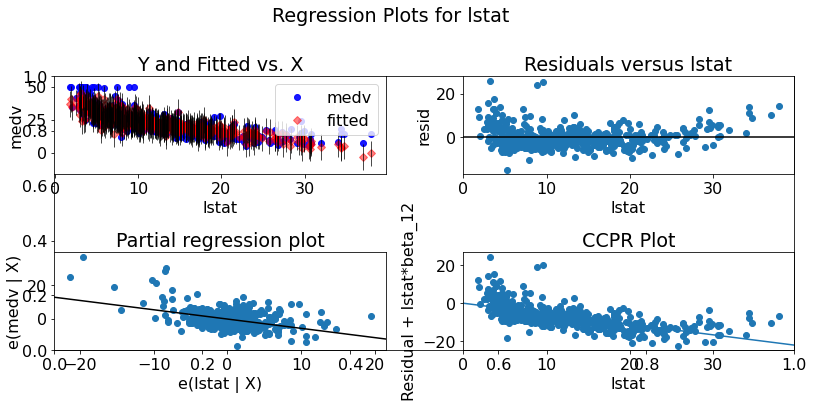

In [37]:
# early attempt at plot(lm.fit) from R
fig, ax = plt.subplots(figsize=(12, 6))
fig = sm.graphics.plot_regress_exog(mlr_results, 'lstat', fig=fig)
fig.tight_layout(pad=1.0)

In [38]:
# VIF
X_df = boston[all_columns_list]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif['variable'] = X_df.columns
vif

,VIF,variable
0,2.077944,crim
1,2.842980,zn
2,14.446693,indus
3,1.148528,chas
4,73.077558,nox
5,76.160431,rm
6,21.350797,age
7,14.576652,dis
8,14.732498,rad
9,61.225416,tax
